## Importing FMoW dataset

In [90]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torch

In [103]:
categories = ["airport", "airport_hangar", "airport_terminal", "amusement_park", "aquaculture", "archaeological_site", "barn", "border_checkpoint", "burial_site", "car_dealership", "construction_site", "crop_field", "dam", "debris_or_rubble", "educational_institution", "electric_substation", "factory_or_powerplant", "fire_station", "flooded_road", "fountain", "gas_station", "golf_course", "ground_transportation_station", "helipad", "hospital", "impoverished_settlement", "interchange", "lake_or_pond", "lighthouse", "military_facility", "multi-unit_residential", "nuclear_powerplant", "office_building", "oil_or_gas_facility", "park", "parking_lot_or_garage", "place_of_worship", "police_station", "port", "prison", "race_track", "railway_bridge", "recreational_facility", "road_bridge", "runway", "shipyard", "shopping_mall", "single-unit_residential", "smokestack", "solar_farm", "space_facility", "stadium", "storage_tank", "surface_mine", "swimming_pool", "toll_booth", "tower", "tunnel_opening", "waste_disposal", "water_treatment_facility", "wind_farm", "zoo"]

class FMoWDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.metadata = pd.read_csv(os.path.join(root_dir, 'rgb_metadata.csv'))
        country_codes_df = pd.read_csv(os.path.join(root_dir, 'country_code_mapping.csv'))
        countrycode_to_region = {k: v for k, v in zip(country_codes_df['alpha-3'], country_codes_df['region'])}
        regions = [countrycode_to_region.get(code, 'Other') for code in self.metadata['country_code'].to_list()]
        self.metadata['region'] = regions

        assert split in ['train', 'val', 'test'], 'split should be either train, val, or test'
        self.metadata = self.metadata[self.metadata['split'] == split]

        self.category_to_idx = {cat: i for i, cat in enumerate(categories)}
        self.metadata['y'] = self.metadata['category'].map(self.category_to_idx)
        self._y_array = torch.tensor(self.metadata['y'].values, dtype=torch.long)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'images', f'rgb_img_{idx}.png')
        image = Image.open(img_name).convert("RGB")
        label = self._y_array[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [104]:
dataset_path = '/mfsnic/u/apouget/data/fmow_v1.1'
transform = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

data_train = FMoWDataset(root_dir=dataset_path, split='train', transform=transform)
dataloader_train = DataLoader(data_train, batch_size=64, shuffle=True, num_workers=4)

torch.Size([64, 3, 224, 224]) torch.Size([64])
tensor([14, 60, 40,  2, 19, 11, 55, 23,  4, 60,  2, 27, 36, 55, 59, 58, 26, 59,
        58, 46, 15, 35, 37,  1, 30, 25, 23, 59, 20, 33, 22, 25, 42, 22, 42, 56,
        29, 51, 44, 11, 36, 30, 33, 29, 33, 19, 36, 39, 52, 11, 14, 56, 53, 22,
        10, 48, 11, 35, 42,  6, 45, 29, 29,  8])
educational_institution


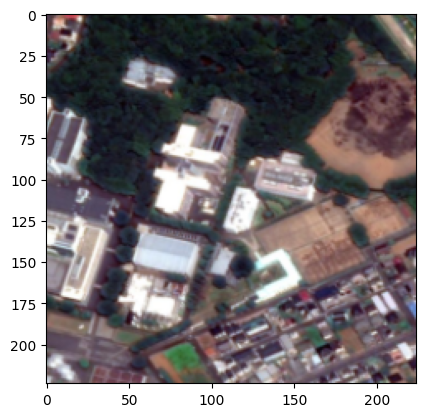

In [114]:
for i, (img, label) in enumerate(dataloader_train):
    if i == 10:
        print(img.shape, label.shape)
        print(label)
        print(categories[int(label[0])])
        plt.imshow(img[0].numpy().transpose((1, 2, 0)))
        break